**Data to mesh**   
Using `nbodykit` to put data on the mesh ([see Painting a Catalog to a Mesh](https://nbodykit.readthedocs.io/en/latest/cookbook/painting.html))
1. read TNG-50 data into memory, convert to nbodykit.catalog
   1. Particle snapshot
   2. subhalo group catalog
2. put all of properties on mesh, including `pos, vel, sfr, etc.`
   1. use `Value` parameter of `to_mesh()` to specify the property
   2. use default setting to get the particle number in each cell

In [2]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.feather as feather
from nbodykit.source.catalog import ArrayCatalog

In [3]:
'''import illustris_python package   
https://www.tng-project.org/data/docs/scripts/
'''
import os
HOME = os.path.expandvars('$HOME')
illustris_python_path = HOME+'/data/mydata/TNG'
if illustris_python_path not in os.sys.path:
    os.sys.path.append(illustris_python_path)
#     os.sys.path.insert(0,illustris_python_path)
# print(f'Our python package path is \n{os.sys.path}')
import illustris_python as ill

# Read data

## particle snapshot

In [16]:
# TNG-50-2-dark
basePath = HOME + '/data/mydata/TNG/TNG50/TNG-50-2-dark/output/'

snapshot_z0 = ill.snapshot.loadSubset(basePath,99,1)  # redshift=0
# snapshot_z10 = ill.snapshot.loadSubset(basePath,4,1)  # redshift=10

In [65]:
# TNG-50-2-hydro
basePath = HOME + '/data/mydata/TNG/TNG50/TNG-50-2-hydro/output/'

dm_snap = ill.snapshot.loadSubset(basePath,99,1)  # redshift=0
# snapshot_z10 = ill.snapshot.loadSubset(basePath,4,1)  # redshift=10

In [67]:
dm_snap.keys()

dict_keys(['count', 'Coordinates', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'TimeStep', 'Velocities'])

In [68]:
pprint(dm_snap)

{'Coordinates': array([[ 7320.39676777, 24545.04553257, 21301.74215301],
       [ 7320.01962762, 24545.88253606, 21301.71631082],
       [ 7319.81212296, 24545.25298931, 21301.91002368],
       ...,
       [32836.0590797 , 25953.79405423, 22999.23007054],
       [34794.2985683 , 30541.40202619, 15992.23971021],
       [29811.47034951, 30297.504004  ,  2659.52467427]]),
 'ParticleIDs': array([ 246453549,  274619053,  246428269, ..., 1259711990, 1259711996,
       1259712000], dtype=uint64),
 'Potential': array([-4624486.5  , -4536184.   , -4547894.5  , ...,   -27773.215,
         -79828.4  ,    27167.354], dtype=float32),
 'SubfindDMDensity': array([1.15510151e-01, 9.95031297e-02, 1.16043046e-01, ...,
       3.14974287e-08, 1.50130916e-07, 3.37779625e-07], dtype=float32),
 'SubfindDensity': array([8.6006460e+00, 3.6029549e+00, 2.3927383e+00, ..., 3.1499440e-08,
       1.5384360e-07, 3.6721076e-07], dtype=float32),
 'SubfindHsml': array([ 0.3169    ,  0.32095408,  0.33131453, ..., 46.675

### convert to catalog

In [87]:
xyz_dict = {0: 'x', 1: 'y', 2: 'z'}

dm_df = pd.DataFrame()
for i in range(3):
    dm_df[xyz_dict[i]] = dm_snap['Coordinates'][:,i]
for i in range(3):
    dm_df['v'+xyz_dict[i]] = dm_snap['Velocities'][:,i]

In [89]:
dm_df[:5]

,x,y,z,vx,vy,vz
0,7320.396768,24545.045533,21301.742153,-2.724034,-130.237595,194.834244
1,7320.019628,24545.882536,21301.716311,-57.519440,-87.426674,-156.271713
2,7319.812123,24545.252989,21301.910024,11.053613,148.860748,193.462601
3,7320.773122,24545.727954,21301.824647,40.403690,146.931046,-175.367508
4,7319.902249,24545.577239,21301.963429,-352.747528,-20.196817,92.991341


### save and load

In [90]:
# save to disk
import pyarrow.feather as feather
feather.write_feather(dm_df, "./tmp_save/TNG-50-hydro-z0-dm-snap.df.feather")

In [47]:
# read from disk
import pyarrow.feather as feather
dm_df = feather.read_feather("./tmp_save/TNG-50-hydro-z0-dm-snap.df.feather")

## subhalo Dataframe

In [15]:
# read data
subhalos_hydro = ill.groupcat.loadSubhalos(HOME + '/data/mydata/TNG/TNG50/TNG-50-2-hydro/output/',99)

In [24]:
from pprint import pprint
pprint(subhalos_hydro,width=30)

{'SubhaloBHMass': array([0.634181  , 0.06940398, 0.02797915, ..., 0.        , 0.        ,
       0.        ], dtype=float32),
 'SubhaloBHMdot': array([3.2096318e-04, 9.9187639e-07, 5.6528893e-07, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32),
 'SubhaloBfldDisk': array([       nan, 0.0030731 , 0.01179466, ..., 0.        , 0.        ,
       0.        ], dtype=float32),
 'SubhaloBfldHalo': array([       nan, 0.00296467,        nan, ..., 0.        , 0.        ,
       0.        ], dtype=float32),
 'SubhaloCM': array([[ 7306.127, 24514.201, 21300.219],
       [ 6787.99 , 24963.754, 21290.572],
       [ 6801.077, 23897.215, 21114.092],
       ...,
       [29618.752, 10851.206, 31429.012],
       [34581.844, 29245.979, 22194.63 ],
       [34739.92 , 21071.766, 11411.112]], dtype=float32),
 'SubhaloFlag': array([ True,  True,  True, ...,  True,  True,  True]),
 'SubhaloGasMetalFractions': array([[7.4533314e-01, 2.4755955e-01, 7.4985268e-04, ..., 3.3060214e-04,
     

In [25]:
subhalos_hydro.keys()

dict_keys(['count', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloFlag', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarMe

### convert to Dataframe

In [48]:
time_start = time()

# keys we care
keys_selected = [
    'SubhaloFlag', 'SubhaloGrNr', \
    'SubhaloPos', 'SubhaloVel',\
    'SubhaloLen', 'SubhaloMass',  'SubhaloMassInRad', 'SubhaloSFR',\
    'SubhaloSpin',\
    'SubhaloHalfmassRad', 'SubhaloStellarPhotometricsRad','SubhaloVelDisp', 'SubhaloVmax',\
    'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldHalo', \
    'SubhaloGasMetallicity', 'SubhaloStarMetallicity', 'SubhaloGasMetalFractions', 'SubhaloStarMetalFractions',\
    'SubhaloStellarPhotometrics'
]

subhalo_df = pd.DataFrame()  # init
# assign value to df
xyz_dict = {0: 'x', 1: 'y', 2: 'z'}
photo_dict = {
    0: 'U', 1: 'B', 2: 'V', 3: 'K',
    4: 'g', 5: 'r', 6: 'i', 7: 'z'
}
for key in keys_selected:
    print(f'processing {key}, \nIts shape is {np.shape(subhalos_hydro[key])}')
    if key in ['SubhaloPos','SubhaloVel','SubhaloSpin']:
        for i in range(3):
            subhalo_df[key+'_'+xyz_dict[i]] = subhalos_hydro[key][:,i]
    elif key in ['SubhaloGasMetalFractions','SubhaloStarMetalFractions']:
        subhalo_df[key+'_H'] = subhalos_hydro[key][:,0]
    elif key == 'SubhaloStellarPhotometrics':
        for i in range(8):
            subhalo_df[key+'_'+photo_dict[i]] = subhalos_hydro[key][:,i]
    else:
        subhalo_df[key] = subhalos_hydro[key]
    pass

time_end = time()
print(f"Done in {time_end - time_start} second")

processing SubhaloFlag, 
Its shape is (859077,)
processing SubhaloGrNr, 
Its shape is (859077,)
processing SubhaloPos, 
Its shape is (859077, 3)
processing SubhaloVel, 
Its shape is (859077, 3)
processing SubhaloLen, 
Its shape is (859077,)
processing SubhaloMass, 
Its shape is (859077,)
processing SubhaloMassInRad, 
Its shape is (859077,)
processing SubhaloSFR, 
Its shape is (859077,)
processing SubhaloSpin, 
Its shape is (859077, 3)
processing SubhaloHalfmassRad, 
Its shape is (859077,)
processing SubhaloStellarPhotometricsRad, 
Its shape is (859077,)
processing SubhaloVelDisp, 
Its shape is (859077,)
processing SubhaloVmax, 
Its shape is (859077,)
processing SubhaloBHMass, 
Its shape is (859077,)
processing SubhaloBHMdot, 
Its shape is (859077,)
processing SubhaloBfldHalo, 
Its shape is (859077,)
processing SubhaloGasMetallicity, 
Its shape is (859077,)
processing SubhaloStarMetallicity, 
Its shape is (859077,)
processing SubhaloGasMetalFractions, 
Its shape is (859077, 10)
processi

In [39]:
subhalo_df[61:65]

,SubhaloFlag,SubhaloGrNr,SubhaloPos_x,SubhaloPos_y,SubhaloPos_z,SubhaloVel_x,SubhaloVel_y,SubhaloVel_z,SubhaloLen,SubhaloMass,...,SubhaloGasMetalFractions_H,SubhaloStarMetalFractions_H,SubhaloStellarPhotometrics_U,SubhaloStellarPhotometrics_B,SubhaloStellarPhotometrics_V,SubhaloStellarPhotometrics_K,SubhaloStellarPhotometrics_g,SubhaloStellarPhotometrics_r,SubhaloStellarPhotometrics_i,SubhaloStellarPhotometrics_z
61,True,0,6487.588379,25030.939453,20922.052734,27.461630,-437.334747,-410.254547,20299,3.495228,...,0.0,0.740362,-16.754200,-17.111168,-17.943592,-20.732918,-17.554319,-18.271423,-18.608555,-18.837973
62,False,0,7314.802734,24685.427734,21373.167969,124.699272,-472.706177,-68.941582,19986,0.518906,...,0.0,0.669316,-16.703707,-17.340807,-18.318331,-21.564293,-17.839891,-18.693113,-19.099060,-19.410948
63,False,0,7296.033691,24455.908203,21254.376953,109.629295,254.160568,604.240845,19636,0.617575,...,0.0,0.665053,-17.685072,-18.190443,-19.092861,-22.170485,-18.661734,-19.440228,-19.809540,-20.090055
64,True,0,7317.954102,24477.970703,21305.128906,241.255859,405.476654,-119.963188,19179,1.006559,...,0.0,0.716263,-16.881115,-17.441099,-18.382889,-21.515385,-17.926704,-18.746441,-19.136642,-19.429062


In [40]:
subhalo_df.shape

(859077, 34)

In [60]:
subhalo_df.index.max()

859076

### drop fake subhalo

In [61]:
subhalo_df.drop(subhalo_df[~subhalo_df['SubhaloFlag']].index,inplace=True)
subhalo_df.drop(columns='SubhaloFlag',inplace=True)
subhalo_df.reset_index(inplace=True,drop=True)
subhalo_df.shape

(857818, 33)

### save and load

In [63]:
# save to disk
import pyarrow.feather as feather
feather.write_feather(subhalo_df, "./tmp_save/TNG-50-hydro-z0-subhalo-catalog.df.feather")

In [ ]:
# load from disk
import pyarrow.feather as feather
subhalo_df = feather.read_feather("./tmp_save/TNG-50-hydro-z0-subhalo-catalog.df.feather")

# Go to mesh🥳


## make catalog
We need to convert the data in memory to *nbodykit catalog* 👇
> [make catalog from memory](https://nbodykit.readthedocs.io/en/latest/catalogs/reading.html#Adapting-in-memory-data-to-a-Catalog)

Parameters:
- `Position`[Mpc/h]: (x,y,z)
- 

In [ ]:
from nbodykit.source.catalog import ArrayCatalog

f = ArrayCatalog({'Position' : data['Position'], 'Mass' : data['Mass'] })
试试pandas格式，若不行，则 df 转 dict

https://rainwoodman.github.io/pmesh/_modules/pmesh/window.html#FindResampler
        NEAREST = ResampleWindow(kind="nearest"),
    LINEAR = ResampleWindow(kind="linear"),
    NNB = ResampleWindow(kind="tunednnb"),
    CIC = ResampleWindow(kind="tunedcic"),
    TSC = ResampleWindow(kind="tunedtsc"),
    PCS = ResampleWindow(kind="tunedpcs"),

In [54]:
from nbodykit.lab import *
redshift = 0
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=35., Nmesh=10, bias=1.0, seed=42)

In [ ]:
cat.to_mesh()

In [201]:
cat.attrs

{'transfer': 'EisensteinHu',
 'cosmo': {'output': 'vTk dTk mPk',
  'extra metric transfer functions': 'y',
  'h': 0.6774,
  'N_ur': 2.0328,
  'gauge': 'synchronous',
  'n_s': 0.9667,
  'ln10^{10}A_s': 3.064,
  'k_pivot': 0.05,
  'tau_reio': 0.066,
  'T_cmb': 2.7255,
  'Omega_cdm': 0.2589,
  'Omega_b': 0.0486,
  'Omega_k': 0.0,
  'N_ncdm': 1,
  'm_ncdm': [0.06],
  'P_k_max_h/Mpc': 10.0,
  'z_max_pk': 100.0},
 'redshift': 0,
 'sigma8': 0.8158116144901115,
 'nbar': 0.003,
 'bias': 1.0,
 'unitary_amplitude': False,
 'inverted_phase': False,
 'seed': 42,
 'Nmesh': array([10, 10, 10]),
 'BoxSize': array([35., 35., 35.])}

In [103]:
cat.columns

['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight']

In [102]:
cat['Position'].compute()[:5]

array([[ 1.3550301,  1.5335696,  8.9352455],
       [ 1.9416637,  9.315755 ,  6.3186336],
       [ 1.8797947, 14.449267 ,  3.7677681],
       [34.656265 , 11.379529 , 29.57557  ],
       [34.96308  , 23.10876  , 10.878756 ]], dtype=float32)

In [106]:
cat['Position'].max().compute()

34.96308

In [104]:
cat['Velocity'].compute()[:5]

array([[ -23.38592 ,  -70.38763 ,  -35.8952  ],
       [ -51.61586 ,  -15.419132,   85.02745 ],
       [ -71.107285,   38.684956,   77.35875 ],
       [-109.98153 , -175.69435 ,  309.67532 ],
       [ -21.077576,  267.04242 , -309.55603 ]], dtype=float32)

In [105]:
cat['VelocityOffset'].compute()[:5]

array([[-0.2338592 , -0.70387626, -0.358952  ],
       [-0.5161586 , -0.15419133,  0.8502745 ],
       [-0.71107286,  0.38684958,  0.77358747],
       [-1.0998152 , -1.7569435 ,  3.0967534 ],
       [-0.21077576,  2.6704242 , -3.0955603 ]], dtype=float32)

In [114]:
subhalo_df.loc[0:10,['SubhaloPos_x','SubhaloPos_y','SubhaloPos_z']].values

array([[ 7320.264 , 24545.36  , 21301.7   ],
       [ 6787.4624, 24964.396 , 21290.254 ],
       [ 6794.6924, 23893.287 , 21114.664 ],
       [ 7411.079 , 25166.357 , 20760.98  ],
       [ 7394.866 , 25550.693 , 21564.033 ],
       [ 8056.3755, 24396.15  , 20880.13  ],
       [ 7200.2017, 24522.857 , 21226.637 ],
       [ 7812.019 , 25034.877 , 22199.988 ],
       [ 6461.0366, 24306.516 , 20959.791 ],
       [ 7138.06  , 25228.848 , 21770.2   ],
       [ 7181.016 , 23440.088 , 21387.76  ]], dtype=float32)

In [108]:
dm_df.loc[:,['x','y','z']].values

,x,y
0,7320.396768,24545.045533
1,7320.019628,24545.882536
2,7319.812123,24545.252989
3,7320.773122,24545.727954
4,7319.902249,24545.577239
...,...,...
1259711995,29707.210451,23196.434624
1259711996,30709.275155,29265.152329
1259711997,32836.059080,25953.794054
1259711998,34794.298568,30541.402026


In [185]:
print(f"x max is {dm_df['x'].max()}, min is {dm_df['x'].min()}")
print(f"x max is {dm_df['y'].max()}, min is {dm_df['y'].min()}")
print(f"x max is {dm_df['z'].max()}, min is {dm_df['z'].min()}")

x max is 34999.999921632334, min is 8.414743933826685e-05
x max is 34999.99995750786, min is 7.5256937748652275e-06
x max is 34999.99999552433, min is 8.868046272510535e-05


In [186]:
BoxSize

33.87

In [198]:
'''dark matter particles
Position[kpc/h]: x,y,z
Velocity[km/s]: vx,vy,vz
'''
from nbodykit.source.catalog import ArrayCatalog

h=0.6774
BoxSize = 35  #50 * h  # [Mpc/h]
Nmesh = 10 * 64  # 10 mini-box
end = 100000

cat = ArrayCatalog({
    'Position': dm_df.loc[0:end,['x','y','z']].values/1000,
    'vx': dm_df.loc[0:end,['vx']].values[:,0],
    'vy': dm_df.loc[0:end,['vy']].values[:,0],
    'vz': dm_df.loc[0:end,['vz']].values[:,0]
})

In [199]:
cat.attrs

{}

In [172]:
cat['vx']

dask.array<array, shape=(100001,), dtype=float32, chunksize=(100000,), chunktype=numpy.ndarray>

## to mesh
We can use many methods to **assign value** on mesh, such as `CIC, TSC, etc.`
> [list of `window function`](https://rainwoodman.github.io/pmesh/_modules/pmesh/window.html#FindResampler)

If we wanna use maximum/minimum rather than sum/average of all values in one cell,   
we need to change the source code of `pmesh` **(to do)**   

**Be careful** of `compensated` and `interlacing` 👇
> [docs of `interlacing`](https://nbodykit.readthedocs.io/en/latest/mesh/creating.html#Compensation:-Deconvolving-the-Window-Kernel)

In [180]:
# convert to mesh object 
# cic, NEAREST
%time mesh = cat.to_mesh(BoxSize=BoxSize, Nmesh=Nmesh, value='vz', resampler='nearest',interlaced=True)
# start paint value on mesh!!!
%time meshed_data = mesh.paint(mode='real')

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10 ms
CPU times: user 19.3 s, sys: 2.1 s, total: 21.4 s
Wall time: 21.4 s


In [174]:
meshed_data.attrs

{'shotnoise': 0.3885449305806941,
 'N': 100001,
 'W': 100001.0,
 'W2': 100001.0,
 'num_per_cell': 0.00038147354125976564,
 'BoxSize': array([33.87, 33.87, 33.87]),
 'Nmesh': array([640, 640, 640]),
 'interlaced': True,
 'compensated': True,
 'resampler': 'cic'}

In [178]:
type(meshed_data.value)

numpy.ndarray

In [141]:
meshed_data.

RealField:array([[[-0.04609776,  0.2755432 , -0.00356293, ...,  0.36770606,
         -0.08639199,  0.3272416 ],
        [ 0.00555611, -0.24242973, -0.03338623, ..., -0.3351032 ,
          0.04596901, -0.28732342],
        [ 0.03599548,  0.2036581 ,  0.08020782, ...,  0.29759443,
         -0.00457209,  0.25118154],
        ...,
        [ 0.17528534, -0.38974857,  0.13364029, ..., -0.47982067,
          0.21519601, -0.4305938 ],
        [-0.12747002,  0.3451681 , -0.09017944, ...,  0.44240856,
         -0.17014831,  0.39791864],
        [ 0.08850002, -0.31291485,  0.04830551, ..., -0.41018337,
          0.12889689, -0.36406833]],

       [[ 0.00584126, -0.23991299, -0.03537369, ..., -0.3326608 ,
          0.04429913, -0.2917139 ],
        [ 0.03467178,  0.20907879,  0.07460785, ...,  0.3057496 ,
         -0.00570393,  0.25525308],
        [-0.07613754, -0.17161942, -0.11930084, ..., -0.26500076,
         -0.03337413, -0.21822214],
        ...,
        [-0.13709164,  0.35651875, -0.090560

In [140]:
type(mesh)

nbodykit.source.mesh.catalog.CatalogMesh

# Script (complete)
We need to use **`MPI`** to speedup the whole process.

## dm particle position

In [ ]:
import numpy as np
import pyarrow.feather as feather
from nbodykit.source.catalog import ArrayCatalog
from nbodykit import setup_logging

setup_logging("debug")

'''load data'''
dm_df = feather.read_feather("./tmp_save/TNG-50-hydro-z0-dm-snap.df.feather")

'''make catalog for nbodykit
Position[Mpc/h]: (x,y,z) We need to /1000 so that [kpc/h] -> [Mpc/h]
'''
h = 0.6774
BoxSize = 35  # [Mpc/h]
Nmesh = 64 * 10  # 10 mini-box
cat = ArrayCatalog({
    'Position': dm_df.loc[:,['x','y','z']].values/1000
})

'''paint on mesh!'''
# convert to mesh object
mesh = cat.to_mesh(BoxSize=BoxSize, Nmesh=Nmesh, value='Value',
                   resampler='cic',compensated=True)
# start paint value on mesh!!!
meshed_data = mesh.paint(mode='real')

'''save result'''
np.save("./tmp_save/TNG-50-hydro-z0-dm-mesh-pos.npy",meshed_data.value)

In [197]:
np.array([[1,2],[6,6,6,8]])#, dtype=object)

<ipython-input-197-b947202c336f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[1,2],[6,6,6,8]])#, dtype=object)


array([list([1, 2]), list([6, 6, 6, 8])], dtype=object)

## dm particle velocity

In [ ]:
import numpy as np
import pyarrow.feather as feather
from nbodykit.source.catalog import ArrayCatalog
from nbodykit import setup_logging

setup_logging("debug")

'''load data'''
dm_df = feather.read_feather("./tmp_save/TNG-50-hydro-z0-dm-snap.df.feather")

'''make catalog for nbodykit
Position[Mpc/h]: (x,y,z) We need to /1000 so that [kpc/h] -> [Mpc/h]
'''
BoxSize = 35  # [Mpc/h]
Nmesh = 64 * 10  # 10 mini-box
cat = ArrayCatalog({
    'Position': dm_df.loc[:,['x','y','z']].values/1000,
    'vx': dm_df.loc[:,['vx']].values[:,0],
    'vy': dm_df.loc[:,['vy']].values[:,0],
    'vz': dm_df.loc[:,['vz']].values[:,0]
})

'''paint on mesh!'''
# convert to mesh object
mesh = cat.to_mesh(BoxSize=BoxSize, Nmesh=Nmesh,
                   resampler='nearest')
meshx = cat.to_mesh(BoxSize=BoxSize, Nmesh=Nmesh, value='vx', 
                    resampler='nearest')
meshy = cat.to_mesh(BoxSize=BoxSize, Nmesh=Nmesh, value='vy', 
                    resampler='nearest')
meshz = cat.to_mesh(BoxSize=BoxSize, Nmesh=Nmesh, value='vz', 
                    resampler='nearest')
# start paint value on mesh!!!
meshed = mesh.paint(mode='real')
meshed_x = meshx.paint(mode='real')
meshed_y = meshy.paint(mode='real')
meshed_z = meshz.paint(mode='real')

'''save result'''
np.save("./tmp_save/TNG-50-hydro-z0-dm-mesh-v-num.npy",meshed.value)
np.save("./tmp_save/TNG-50-hydro-z0-dm-mesh-vx.npy",meshed_x.value)
np.save("./tmp_save/TNG-50-hydro-z0-dm-mesh-vy.npy",meshed_y.value)
np.save("./tmp_save/TNG-50-hydro-z0-dm-mesh-vz.npy",meshed_z.value)

## subhalo properties

In [ ]:
import numpy as np
import pyarrow.feather as feather
from nbodykit.source.catalog import ArrayCatalog
from nbodykit import setup_logging

setup_logging("debug")

'''load data'''
subhalo_df = feather.read_feather("./tmp_save/TNG-50-hydro-z0-subhalo-catalog.df.feather")

'''make catalog for nbodykit
Position[Mpc/h]: (x,y,z) We need to /1000 so that [kpc/h] -> [Mpc/h]
'''
BoxSize = 35  # [Mpc/h]
Nmesh = 64 * 10  # 10 mini-box
cat = ArrayCatalog({
    'Position': subhalo_df.loc[:,['SubhaloPos_x','SubhaloPos_y','SubhaloPos_z']].values/1000
})
subhalo_df.drop(columns=['SubhaloLen','SubhaloGrNr','SubhaloPos_x','SubhaloPos_y','SubhaloPos_z'],inplace=True)
keys = subhalo_df.columns.to_list()
for key in keys:
    cat[key] = subhalo_df.loc[:,key].values
    pass

'''paint to mesh'''
def _goto_mesh(key):
    if key == 'Position':
        value = 'Value'
    else:
        value = key
    mesh = cat.to_mesh(BoxSize=BoxSize, Nmesh=Nmesh, resampler='nearest', value=value)
    meshed = mesh.paint(mode='real')
    np.save(f"./tmp_save/TNG-50-hydro-z0-subhalo-{key}.npy",meshed.value)
    return

'''multiprocessing'''
#************************************************************************************
from multiprocessing import Pool
from time import time

pool = Pool(processes=len(keys))
time_start = time()

tmp_data = list(pool.map(
    _goto_mesh,
    keys + ['Position']
))

pool.close()
pool.join()
print(f"Done in {time() - time_start} second")
#************************************************************************************

# check data

In [48]:
dm_df[:5]

,x,y,z,vx,vy,vz
0,7320.396768,24545.045533,21301.742153,-2.724034,-130.237595,194.834244
1,7320.019628,24545.882536,21301.716311,-57.519440,-87.426674,-156.271713
2,7319.812123,24545.252989,21301.910024,11.053613,148.860748,193.462601
3,7320.773122,24545.727954,21301.824647,40.403690,146.931046,-175.367508
4,7319.902249,24545.577239,21301.963429,-352.747528,-20.196817,92.991341


In [50]:
dm_df.describe()

,x,y,z,vx,vy,vz
count,1.259712e+09,1.259712e+09,1.259712e+09,1.259712e+09,1.259712e+09,1.259712e+09
mean,1.709974e+04,1.737814e+04,1.702135e+04,4.525835e-02,3.388255e-02,-3.038954e-01
std,1.003222e+04,9.724288e+03,1.002110e+04,2.036886e+02,2.137296e+02,2.165134e+02
min,8.414744e-05,7.525694e-06,8.868046e-05,-2.474417e+03,-2.431699e+03,-2.485609e+03
25%,7.723628e+03,7.909365e+03,7.429681e+03,-9.563354e+01,-1.010694e+02,-1.019700e+02
50%,1.753870e+04,1.866768e+04,1.753095e+04,-3.890373e+00,-4.759888e+00,3.337295e+00
75%,2.497681e+04,2.503807e+04,2.522743e+04,9.500478e+01,9.917582e+01,1.037777e+02
max,3.500000e+04,3.500000e+04,3.500000e+04,2.374072e+03,2.395897e+03,2.359285e+03


In [75]:
dm_test = np.load('./tmp_save/TNG-50-hydro-z0-dm-mesh-pos.npy')

In [77]:
dm_test.max()

117846.77

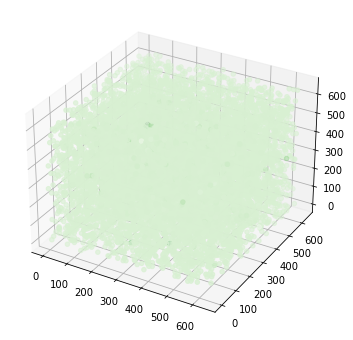

In [28]:
# dm_test = np.random.random((16,16,16))

idxs = list(itertools.product(range(dm_test.shape[0]),repeat=3))
colors = np.array([dm_test[idx] for idx in idxs])

sel_idx = np.random.randint(0,dm_test.size,10000)
idxs = np.array(idxs)[sel_idx].tolist()
colors = colors[sel_idx]

x,y,z = np.hsplit(np.array(idxs),3)

plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=colors, cmap='Greens')
plt.show()

In [ ]:
from nbodykit.lab import LinearMesh, cosmology
from matplotlib import pyplot as plt

cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift=0, transfer='EisensteinHu')

# initialize the mesh
mesh = LinearMesh(Plin, Nmesh=128, BoxSize=1380, seed=42)

# preview the density field
plt.imshow(mesh.preview(axes=[0,1]))

In [83]:
'''check subhalo to mesh'''
subhalo_test = np.load("./tmp_save/subhalo.v1/TNG-50-hydro-z0-subhalo-SubhaloSFR.npy")

In [86]:
subhalo_test.max()

11071.792

In [87]:
subhalo_df = feather.read_feather("./tmp_save/TNG-50-hydro-z0-subhalo-catalog.df.feather")

In [93]:
subhalo_df.columns

Index(['SubhaloGrNr', 'SubhaloPos_x', 'SubhaloPos_y', 'SubhaloPos_z',
       'SubhaloVel_x', 'SubhaloVel_y', 'SubhaloVel_z', 'SubhaloLen',
       'SubhaloMass', 'SubhaloMassInRad', 'SubhaloSFR', 'SubhaloSpin_x',
       'SubhaloSpin_y', 'SubhaloSpin_z', 'SubhaloHalfmassRad',
       'SubhaloStellarPhotometricsRad', 'SubhaloVelDisp', 'SubhaloVmax',
       'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldHalo',
       'SubhaloGasMetallicity', 'SubhaloStarMetallicity',
       'SubhaloGasMetalFractions_H', 'SubhaloStarMetalFractions_H',
       'SubhaloStellarPhotometrics_U', 'SubhaloStellarPhotometrics_B',
       'SubhaloStellarPhotometrics_V', 'SubhaloStellarPhotometrics_K',
       'SubhaloStellarPhotometrics_g', 'SubhaloStellarPhotometrics_r',
       'SubhaloStellarPhotometrics_i', 'SubhaloStellarPhotometrics_z'],
      dtype='object')

In [89]:
tmp = subhalo_df['SubhaloStellarPhotometrics_g'].values


array([-24.730139, -21.775595, -21.48687 , ...,  -8.486084,  -8.542626,
        -8.324519], dtype=float32)

In [91]:
tmp[tmp<100].max()

-6.128654

In [96]:
tmp1 = np.load('./tmp_save/TNG-50-hydro-z0-subhalo-SubhaloStellarPhotometrics_K.npy')
tmp2 = np.load('./tmp_save/subhalo.v1/TNG-50-hydro-z0-subhalo-SubhaloStellarPhotometrics_K.npy')

In [100]:
tmp1.min()

-25858.58

In [102]:
tmp1 = np.load('./tmp_save/TNG-50-hydro-z0-subhalo-SubhaloBHMdot.npy')
tmp2 = np.load('./tmp_save/subhalo.v1/TNG-50-hydro-z0-subhalo-SubhaloBHMdot.npy')

In [118]:
subhalomass = np.load('./tmp_save/TNG-50-hydro-z0-subhalo-SubhaloMass.npy')
subhalonums = np.load('./tmp_save/TNG-50-hydro-z0-subhalo-Position.npy')

In [139]:
dmvelx = np.load('./tmp_save/TNG-50-hydro-z0-dm-mesh-vx.npy')
dmnums = np.load('./tmp_save/TNG-50-hydro-z0-dm-mesh-v-num.npy')

In [155]:
dmnums.max()

151977.36

In [157]:
INPUT = {
    'dm_velx': 'TNG-50-hydro-z0-dm-mesh-vx.npy',
    'dm_vely': 'TNG-50-hydro-z0-dm-mesh-vy.npy',
    'dm_velz': 'TNG-50-hydro-z0-dm-mesh-vz.npy',
    'dm_mass': 'TNG-50-hydro-z0-dm-mesh-v-num.npy'
}
INPUT.keys

<function dict.keys>

In [119]:
subhalomass_avg = np.divide(subhalomass, subhalonums)

<ipython-input-119-1722db642511>:1: RuntimeWarning: invalid value encountered in true_divide
  subhalomass_avg = np.divide(subhalomass, subhalonums)


In [143]:
dmvelx_avg = np.divide(dmvelx, dmnums)

<ipython-input-143-36b2ba3b5080>:1: RuntimeWarning: invalid value encountered in true_divide
  dmvelx_avg = np.divide(dmvelx, dmnums)


In [123]:
np.nan_to_num(subhalomass_avg, copy=False,nan=0)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [144]:
np.nan_to_num(dmvelx_avg, copy=False, nan=0)

array([[[  0.       , -11.876677 ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        [-10.324741 , -11.677489 ,   0.       , ...,  -7.5857115,
           0.       ,   0.       ],
        [-10.690854 ,   0.       ,   0.       , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [  0.       , -12.027234 , -23.363968 , ...,  -8.641777 ,
           0.       ,   0.       ],
        [-10.773733 ,   0.       , -14.361497 , ...,   0.       ,
           0.       ,   0.       ],
        [-10.596284 , -12.594373 , -13.635618 , ...,   0.       ,
          -9.413936 ,   0.       ]],

       [[  0.       , -11.243395 , -26.67489  , ...,  -7.3622723,
           0.       ,   0.       ],
        [  0.       ,   0.       , -16.954464 , ...,   0.       ,
           0.       ,  -8.920744 ],
        [  0.       ,   0.       , -21.248816 , ...,   0.       ,
           0.       ,   0.       ],
        ...,
        [-19.856909 ,   0.       , -13.696912 , ...,  

[ 2336601.00 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    vmin 1.050158638068528 vmax 1500744.690248557
[ 2336601.01 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08])
[ 2336601.04 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    vmin 1.050158638068528 vmax 1500744.690248557
[ 2336601.04 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08])
[ 2336601.04 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    vmin 1.050158638068528 vmax 1500744.690248557
[ 2336601.04 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07, 1.e+08])
[ 2336601.04 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    vmin 1.050158638068528 vmax 1500744.690248557
[ 2336601.05 ]   0: 10-25 14:25  matplotlib.ticker DEBUG    ticklocs array([2.e-01, 

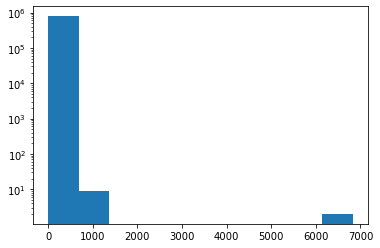

In [159]:
# plt.hist(np.log10(subhalomass_avg[subhalomass_avg!=0]),bins=10)
plt.hist(subhalomass_avg[subhalomass_avg!=0])
# plt.xscale('log')
plt.yscale('log')
plt.show()

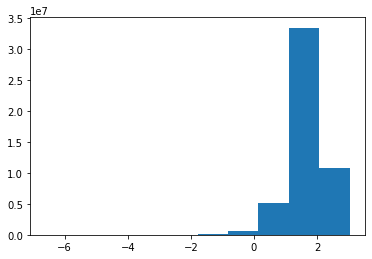

In [153]:
plt.hist(np.log10(dmvelx_avg[dmvelx_avg>0]),bins=10)
# plt.hist(dmvelx_avg.ravel(),bins=10)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [117]:
tmp.max()

4170526.8

In [105]:
np.divide(tmp1,tmp2)

<ipython-input-105-4dcd6f7b1348>:1: RuntimeWarning: invalid value encountered in true_divide
  np.divide(tmp1,tmp2)


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan